In [1]:
%matplotlib inline

In [2]:
# make survos2 importable
import sys
sys.path.append("./..")

lets import the relavent functions

In [3]:
from survos2.improc.regions.slic import slic3d as cuda_slic

In [4]:
import numpy as np
from skimage import data, color, filters, segmentation
from skimage.util import img_as_float32, img_as_float64
from skimage.segmentation import slic as sk_slic
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt
from ipywidgets import interact
import time

Comparing speed between cuda-slic and skslic

cuda_slic took:
1.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
sk_slic took:
1.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


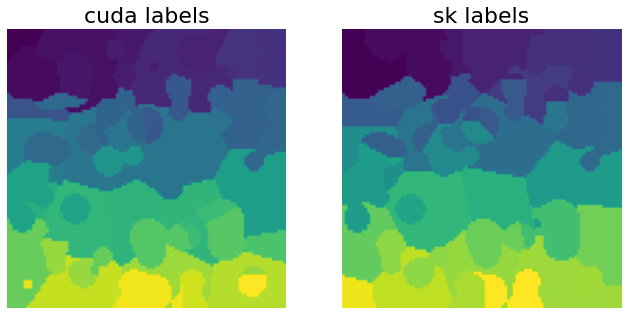

In [5]:
# initializing a 3 dim dataset
blob = data.binary_blobs(length=100, n_dim=3, seed=2)
blob = img_as_float32(blob)

print("cuda_slic took:")
%timeit -n1 -r1 cuda_labels = cuda_slic(blob, nsp=200, compactness=30)
cuda_labels = cuda_slic(blob, nsp=200, compactness=30)

#blob = img_as_float64(blob)
print("sk_slic took:")
%timeit -n1 -r1 sk_labels = sk_slic(blob, n_segments=200, compactness=1,  multichannel=False)
sk_labels = sk_slic(blob, n_segments=200, compactness=1,  multichannel=False)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,6))
ax1.imshow(cuda_labels[...,0]); ax1.axis("off"); ax1.set_title("cuda labels", size=22);
ax2.imshow(sk_labels[...,0]); ax2.axis("off"); ax2.set_title("sk labels", size=22);

lets explore the segmentation of the whole 3D array

In [6]:
marked_blob = mark_boundaries(color.gray2rgb(blob), cuda_labels)

In [7]:
def plot_slice(images, z, cols=2, titles=None):
    rows = (len(images)+cols-1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*8))
    for i in range(len(images)):
        axes[i].imshow(images[i][:,:,z])
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i], size=32)

In [8]:
from ipywidgets import IntSlider, fixed
interact(plot_slice,
         images=fixed([marked_blob, blob]),
         titles=fixed(None),
         z=IntSlider(min=0, max=99),
         cols=fixed(2));

interactive(children=(IntSlider(value=0, description='z', max=99), Output()), _dom_classes=('widget-interact',…

exploring the `n_segments` parameter and `compactness` parameter for cuda_slic and sk_slic

In [27]:
blob = data.binary_blobs(length=200, n_dim=3, seed=2)
blob = filters.gaussian(blob)
blob = blob[:,:,:10]
blob = filters.gaussian(blob)
blob = img_as_float32(blob)

In [28]:
def compare_slic_algos(cuda_c, sk_c, n_segments=100, z=0):
    cuda_labels = cuda_slic(blob, nsp=n_segments, compactness=cuda_c)
    sk_labels = sk_slic(blob, n_segments=n_segments, compactness=sk_c, multichannel=False)
    marked_blob_cuda = mark_boundaries(color.gray2rgb(blob), cuda_labels, color=(0.2, 1, 0))
    marked_blob_sk = mark_boundaries(color.gray2rgb(blob), sk_labels, color=(1, 0.7, 0))
    plot_slice([marked_blob_cuda, marked_blob_sk], z=z, titles=["cuda-slic", "skimage-slic"])

In [29]:
interact(compare_slic_algos,
         cuda_c=(0.001,500,0.01),
         sk_c=(0.001,2.0,0.001),
         n_segments=(5,5000),
         z=IntSlider(min=0, max=9));

interactive(children=(FloatSlider(value=249.991, description='cuda_c', max=500.0, min=0.001, step=0.01), Float…

## Cuda SLIC Failiure Modes
From playing around with the parameters I was able to discover a few inputs that causes the cuda_slic algorithm to throw an error.

### 1. input array (500, 500, 500), nps>50_000, compactness=30:

This usually throughs a `LogicError` exception. When it fails, it leaves memory residue in the GPU that is not cleaned up unless you terminate the pyhton process. 

This error is sometimes generated from the cuda compilation step of the `ccl.py` and sometimes form `slic.py`

Further complicating things the algorithm does not fail reliably with these inputs!!
However, I was able to make it fail reliably with `nps=500_000`. This indicates that the failiure rate is related to the the `nps` parameter.


In [12]:
blob = data.binary_blobs(length=500, n_dim=3, seed=2)
blob = img_as_float32(blob)
cuda_labels = cuda_slic(blob, nsp=50_000, compactness=30)
print(len(np.unique(cuda_labels)))

46661



```
---------------------------------------------------------------------------
LogicError                                Traceback (most recent call last)
<ipython-input-39-ad381aadb072> in <module>
      1 blob = data.binary_blobs(length=500, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=50_000, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     29 
     30     with open(op.join(__dirname__, 'kernels', 'slic3d.cu'), 'r') as f:
---> 31         _mod_conv = SourceModule(f.read())
     32         gpu_slic_init = _mod_conv.get_function('init_clusters')
     33         gpu_slic_expectation = _mod_conv.get_function('expectation')

/scratch/ovs72384/anaconda3/envs/gpu-slic/lib/python3.7/site-packages/pycuda/compiler.py in __init__(self, source, nvcc, options, keep, no_extern_c, arch, code, cache_dir, include_dirs)
    292 
    293         from pycuda.driver import module_from_buffer
--> 294         self.module = module_from_buffer(cubin)
    295 
    296         self._bind_module()

LogicError: cuModuleLoadDataEx failed: an illegal memory access was encountered -
```

Interestingly, `sk_slic` drops out and refuses to segment the array to more than 250_000 groups. For example

In [13]:
sk_labels = sk_slic(blob, n_segments=5_000_000, compactness=1)
print(len(np.unique(sk_labels)))

250000




### 2. input array of size less than (32, 32, 32) fails with "`IndexError`: too many indices for array"

In [14]:
blob = data.binary_blobs(length=31, n_dim=3, seed=2)
blob = img_as_float32(blob)
cuda_labels = cuda_slic(blob, nsp=10, compactness=30)
print(len(np.unique(cuda_labels)))

IndexError: too many indices for array

```
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
<ipython-input-22-0316eb65c967> in <module>
      1 blob = data.binary_blobs(length=31, n_dim=3, seed=2)
      2 blob = img_as_float32(blob)
----> 3 cuda_labels = cuda_slic(blob, nsp=10, compactness=30)
      4 print(len(np.unique(cuda_labels)))

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/cuda.py in wrapper(keep_gpu, *args, **kwargs)
     37     @wraps(func)
     38     def wrapper(*args, keep_gpu=False, **kwargs):
---> 39         r = func(*args, **kwargs)
     40         return asgpuarray(r, dtype) if keep_gpu else asnparray(r, dtype)
     41     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/slic.py in slic3d(data, nsp, sp_shape, compactness, sigma, spacing, max_iter, postprocess)
     85     if postprocess:
     86         min_size = int(np.prod(_sp_shape) / 10.)
---> 87         r = merge_small(asnparray(data), r, min_size)
     88         binlab = np.bincount(r.ravel())
     89 

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(out, src_mode, *args, **kwargs)
    563                          fillvalue=fillvalue, src_mode=src_mode)
    564         with DatasetManager(*args, **dm_params) as DM:
--> 565             result = func(*DM.sources, **kwargs)
    566             if out is not None:
    567                 DM.out[...] = result

~/Projects/gpu-slic/survos2/improc/utils.py in wrapper(*args, **kwargs)
    517     @wraps(func)
    518     def wrapper(*args, **kwargs):
--> 519         r = func(*args, **kwargs)
    520         return r is None or asnparray(r, dtype=dtype)
    521     return wrapper

~/Projects/gpu-slic/survos2/improc/regions/ccl.py in merge_small(data, labels, min_size, **kwargs)
     80         data = data[..., None]
     81     assert data.ndim == labels.ndim + 1
---> 82     return _merge_small3d(data, labels, labels.max()+1, min_size)
     83 
     84 

~/Projects/gpu-slic/survos2/improc/regions/_ccl.pyx in improc.superregions._ccl._merge_small3d()

IndexError: too many indices for array

```